In [10]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import gamma
from models.networks_2022 import BranchedNetwork
from models.pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
from data.ReconstructionTrainingDataset import CleanSoundsDataset
from data.ValidationDataset import NoisyDataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from tensorboard.backend.event_processing import event_accumulator

# Set network parameters

In [3]:
# Which network to test
pnet_name = 'pnet'
chckpt = 1960

In [4]:
engram_dir = '/Users/chingfang/temp_locker/'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'

In [5]:
# Set up parameters
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')
checkpoints_dir = f'{engram_dir}1_checkpoints/'
tensorboard_dir = f'{engram_dir}1_tensorboard/'
activations_dir = f'{engram_dir}3_validation_activations/{pnet_name}/'
hyp_dir = f'{engram_dir}2_hyperp/{pnet_name}/'
PNetClass = PBranchedNetwork_AllSeparateHP
n_timesteps = 5
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']

Device: cuda:0


In [6]:
bg = 'pinkNoise'
snr = -9.0

# Load network

In [32]:
net = BranchedNetwork()
pnet = PNetClass(net, build_graph=True)
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        string = f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t"
        string += f"fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t"
        string += f"erm: {getattr(pnet,f'erm{pc+1}'):0.3f}"
        print(string)
pnet.load_state_dict(torch.load(
    f"{checkpoints_dir}{pnet_name}/{pnet_name}-{chckpt}-regular.pth",
    map_location='cpu'
    ))

/share/ctn/users/cf2794/Code/hallucnn/src/models/layers.py:78: UserWarning: Inconsistent tf pad calculation in ConvLayer.
  warnings.warn('Inconsistent tf pad calculation in ConvLayer.')
/share/ctn/users/cf2794/Code/hallucnn/src/models/layers.py:173: UserWarning: Inconsistent tf pad calculation: 0, 1
  warnings.warn(f'Inconsistent tf pad calculation: {pad_left}, {pad_right}')


<All keys matched successfully>

# Load hyperparameters

In [8]:
def get_hyperparams(tf_filepath, bg, snr):
    hyperparams = []
    ea = event_accumulator.EventAccumulator(tf_filepath)
    ea.Reload()
    eval_score = [0]
    epoch = 0
    while True:
        try:
            score_over_t = 0.
            for t in np.arange(1,5):
                score_over_t += ea.Scalars(f'NoisyPerf/Epoch#{epoch}')[t].value
                epoch += 1
            score_over_t /= 4
            eval_score.append(score_over_t)
        except Exception as e:
            break
    for i in range(1, 6):
        hps = {}
        ffm = ea.Scalars(f'Hyperparam/pcoder{i}_feedforward')[-1].value
        fbm = ea.Scalars(f'Hyperparam/pcoder{i}_feedback')[-1].value
        erm = ea.Scalars(f'Hyperparam/pcoder{i}_error')[-1].value
        if np.isnan(ffm) or np.isnan(fbm) or np.isnan(erm):
            return None, 0.
        hps['ffm'] = ffm
        hps['fbm'] = fbm
        hps['erm'] = erm
        hyperparams.append(hps)
    return hyperparams, eval_score[-1]

def load_pnet(PNetClass, pnet_name, chckpt, hyperparams=None):
    net = BranchedNetwork(track_encoder_representations=True)
    net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))
    pnet = PNetClass(net, build_graph=False)
    pnet.load_state_dict(torch.load(
        f"{checkpoints_dir}{pnet_name}/{pnet_name}-{chckpt}-regular.pth",
        map_location='cpu'
        ))
    if hyperparams is not None:
        pnet.set_hyperparameters(hyperparams)
    pnet.to(DEVICE)
    pnet.eval();
    print(f'Loaded Pnet: {pnet_name}')
    print_hps(pnet)
    return pnet

In [51]:
tf_dir = f'{hyp_dir}hyper_{bg}_snr{snr}/'
best_score = 0.
best_hyperparams = None
best_tf_file = None
for tf_file in os.listdir(tf_dir):
    if not tf_file.startswith('event'): continue
    tf_filepath = f'{tf_dir}{tf_file}'
    tf_file = tf_file.split('edu.')[-1]
    hyperparams, score = get_hyperparams(tf_filepath, bg, snr)
    if score > best_score:
        best_score = score
        best_hyperparams = hyperparams
        best_tf_file = tf_file
print(f'{bg}, SNR {snr} uses {best_tf_file} with valid score {best_score}')

# Use the best hyperparameter set
pnet = load_pnet(PNetClass, pnet_name, chckpt, best_hyperparams)

pinkNoise, SNR -9.0 uses 34545.1 with valid score 0.37640000134706497
Loaded Pnet: pnet
PCoder1 : ffm: 0.749 	fbm: 0.248 	erm: 0.026
PCoder2 : ffm: 0.969 	fbm: 0.031 	erm: -0.002
PCoder3 : ffm: 0.743 	fbm: 0.256 	erm: 0.016
PCoder4 : ffm: 0.133 	fbm: 0.850 	erm: 0.026
PCoder5 : ffm: 0.301 	fbm: 0.000 	erm: -0.041


In [56]:
pnet = load_pnet(PNetClass, pnet_name, chckpt, hyperparams=None)

Loaded Pnet: pnet
PCoder1 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder2 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder3 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder4 : ffm: 0.300 	fbm: 0.300 	erm: 0.010
PCoder5 : ffm: 0.300 	fbm: 0.300 	erm: 0.010


# Clean dataset reconstruction

In [13]:
datafile = f'{engram_dir}clean_reconstruction_training_set.hdf5'

In [14]:
# Set up test dataset
full_dataset = CleanSoundsDataset(datafile)
n_train = int(len(full_dataset)*0.9)
dset = Subset(full_dataset, np.arange(n_train, len(full_dataset)))
del full_dataset

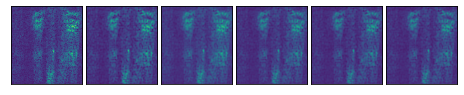

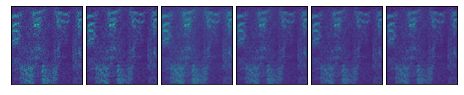

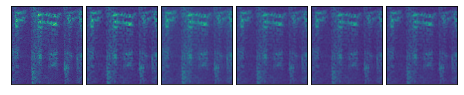

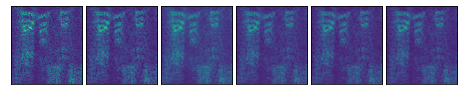

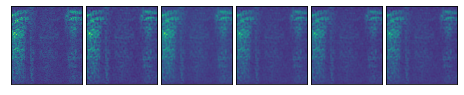

In [77]:
# Plot reconstructions over successive timesteps
for i in range(5):
    pnet.reset()
    fig, axs = plt.subplots(1, 6, figsize = (8, 2))
    imshow_plots = []
    with torch.no_grad():
        for t in range(n_timesteps):
            _input = dset[i][0] if t == 0 else None # Clean cochleagram
            if _input is not None:
                _input = _input.unsqueeze(0)
                original_shape = _input.shape
                _input = _input.flatten()
                nelements = _input.size()[0]
                set_to_zero_indices = np.random.choice(nelements, size=int(nelements*0.4), replace=False)
                _input[set_to_zero_indices] = 0.
                _input = _input.reshape(original_shape)                
                _input = _input.to(DEVICE)
            outputs = pnet(_input)
            reconstruction = np.array(pnet.pcoder1.prd[0,0].cpu())
            if t==0:
                imshow_plots.append(_input.cpu().squeeze())
            imshow_plots.append(reconstruction)
    vmin = min([p.min() for p in imshow_plots])
    vmax = max([p.max() for p in imshow_plots])
    for idx, ax in enumerate(axs):
        ax.imshow(imshow_plots[idx][:,50:200], vmin=vmin, vmax=vmax)
        ax.set_xticks([]); ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(f'../figures/16b_{pnet_name}_input{i}.png', dpi=300)

# Removing a box:

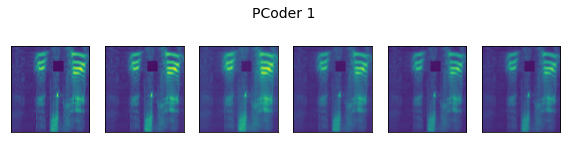

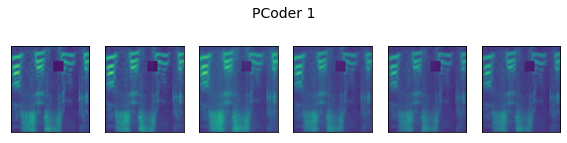

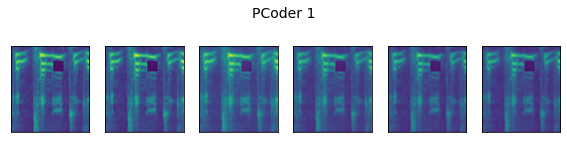

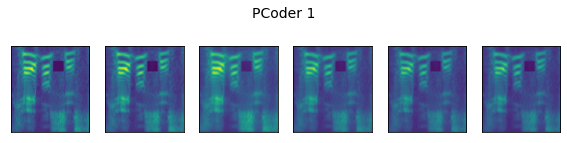

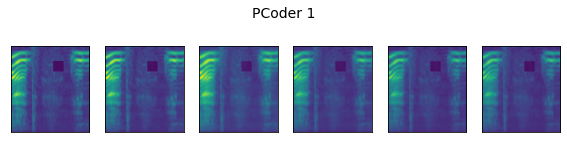

In [71]:
# Plot reconstructions over successive timesteps
for i in range(5):
    pnet.reset()
    fig, axs = plt.subplots(1, 6, figsize = (8, 2))
    #fig, axs = plt.subplots(6, 1, figsize = (6, 8))
    imshow_plots = []
    with torch.no_grad():
        for t in range(n_timesteps):
            _input = dset[i][0] if t == 0 else None # Clean cochleagram
            if _input is not None:
                _input = _input.unsqueeze(0)
                
                # REMOVE BLOCK OR STRIPE
                _input[0,0,30:50,130:150] = 0. # Remove block
                #_input[0,0,:,85:105] = 1E-3 # Remove stripe     
                _input = _input.to(DEVICE)
            outputs = pnet(_input)
            reconstruction = np.array(pnet.pcoder1.prd[0,0].cpu())
            if t==0:
                imshow_plots.append(_input.cpu().squeeze())
            imshow_plots.append(reconstruction)
    vmin = min([p.min() for p in imshow_plots])    
    vmax = max([p.max() for p in imshow_plots])
    for idx, ax in enumerate(axs):
        ax.imshow(imshow_plots[idx][:,50:200], vmin=vmin, vmax=vmax)
        ax.set_xticks([]); ax.set_yticks([])
    plt.suptitle(f'PCoder 1', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'../figures/16b_{pnet_name}_input{i}.png', dpi=300)